# Team Member Details

1. Anvit Gupta, 22114009, CSE 3rd Year
2. Raman Sharma, 22114076, CSE 3rd Year
3. Souvik Karmakar, 22114096, CSE 3rd Year
4. Vineet Kumar, 22114107, CSE 3rd Year

# About Project

The project aims at building the deep learning model to recognize celebrities. The project pipeline is highlighted below :

1. Prepare dataset - Dataset containing 13 classes each corresponding to a celebrity having 250 to 300 images is prepared manually by **merging 3 public datasets** from kaggle.
2. Preprocessing the dataset to make training and validation datasets.
3. Apply **data augmentation** by use of data generators.
4. Deciding the neural network architecture to be used. In this project, we have fine tuned VGG16 CNN architecture.
5. Train the model and plotting the validation loss and accuracy across epochs to verify that model is not overfitting.
6. Inference - Evaluating model on new images from the internet.



# Project Code

In [1]:
!unzip /Dataset.zip

Archive:  /Dataset.zip
   creating: Dataset/
   creating: Dataset/Aishwarya Rai/
  inflating: Dataset/Aishwarya Rai/1.jpg  
  inflating: Dataset/Aishwarya Rai/10.jpeg  
  inflating: Dataset/Aishwarya Rai/100.jpg  
  inflating: Dataset/Aishwarya Rai/101.jpg  
  inflating: Dataset/Aishwarya Rai/102.jpg  
  inflating: Dataset/Aishwarya Rai/103.jpg  
  inflating: Dataset/Aishwarya Rai/104.jpg  
  inflating: Dataset/Aishwarya Rai/105.jpg  
  inflating: Dataset/Aishwarya Rai/106.jpg  
  inflating: Dataset/Aishwarya Rai/108.jpg  
  inflating: Dataset/Aishwarya Rai/109.jpg  
  inflating: Dataset/Aishwarya Rai/11.jpg  
  inflating: Dataset/Aishwarya Rai/110.jpg  
  inflating: Dataset/Aishwarya Rai/113.jpg  
  inflating: Dataset/Aishwarya Rai/114.jpg  
  inflating: Dataset/Aishwarya Rai/115.jpg  
  inflating: Dataset/Aishwarya Rai/116.jpg  
  inflating: Dataset/Aishwarya Rai/118.jpg  
  inflating: Dataset/Aishwarya Rai/119.jpg  
  inflating: Dataset/Aishwarya Rai/12.jpg  
  inflating: Dataset/Ai

In [2]:
import os
import shutil
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Conv2D, MaxPooling2D, BatchNormalization

In [3]:
def split_into_train_and_val(dataset_dir, train_dir, val_dir) :
  for class_name in os.listdir(dataset_dir):
    if class_name == ".config" or class_name == "train" or class_name == "val" or class_name == ".ipynb_checkpoints":
      continue

    class_path = os.path.join(dataset_dir, class_name)

    if os.path.isdir(class_path):
        images = os.listdir(class_path)

        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        for img in train_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))

        for img in val_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

In [4]:
dataset_dir = '/content/Dataset'
train_dir = '/train'
val_dir = '/val'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

split_into_train_and_val(dataset_dir, train_dir, val_dir)

In [5]:
img_height, img_width = 224, 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2936 images belonging to 13 classes.
Found 741 images belonging to 13 classes.


## Model traning and finetuning

In [9]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width,3))

for layer in base_model.layers:
    layer.trainable = False

model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(13, activation='softmax'))

for X_batch, y_batch in train_generator:
    model.predict(X_batch, verbose=0)
    break

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              25691136  
                                                                 
 dense_6 (Dense)             (None, 512)               524800    
                                                                 
 dense_7 (Dense)             (None, 256)               131328    
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 13)               

In [10]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

history1 = model.fit(
    train_generator,
    epochs=10,
    batch_size=batch_size,
    validation_data=validation_generator
)

for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=0.00001), loss='categorical_crossentropy', metrics=['accuracy'])

history2 = model.fit(
    train_generator,
    epochs=10,
    batch_size=batch_size,
    validation_data=validation_generator,
)

Epoch 1/10
92/92 [==============================] - 83s 888ms/step - loss: 2.0959 - accuracy: 0.2677 - val_loss: 1.4402 - val_accuracy: 0.4804
Epoch 2/10
92/92 [==============================] - 80s 869ms/step - loss: 1.5159 - accuracy: 0.4414 - val_loss: 1.3353 - val_accuracy: 0.5115
Epoch 3/10
92/92 [==============================] - 81s 873ms/step - loss: 1.3339 - accuracy: 0.5143 - val_loss: 1.1965 - val_accuracy: 0.5412
Epoch 4/10
92/92 [==============================] - 80s 872ms/step - loss: 1.2137 - accuracy: 0.5552 - val_loss: 1.1174 - val_accuracy: 0.5762
Epoch 5/10
92/92 [==============================] - 80s 871ms/step - loss: 1.0894 - accuracy: 0.6066 - val_loss: 1.0217 - val_accuracy: 0.6356
Epoch 6/10
92/92 [==============================] - 81s 878ms/step - loss: 1.0116 - accuracy: 0.6339 - val_loss: 0.9436 - val_accuracy: 0.6721
Epoch 7/10
92/92 [==============================] - 81s 878ms/step - loss: 0.9185 - accuracy: 0.6734 - val_loss: 0.8950 - val_accuracy: 0.6761

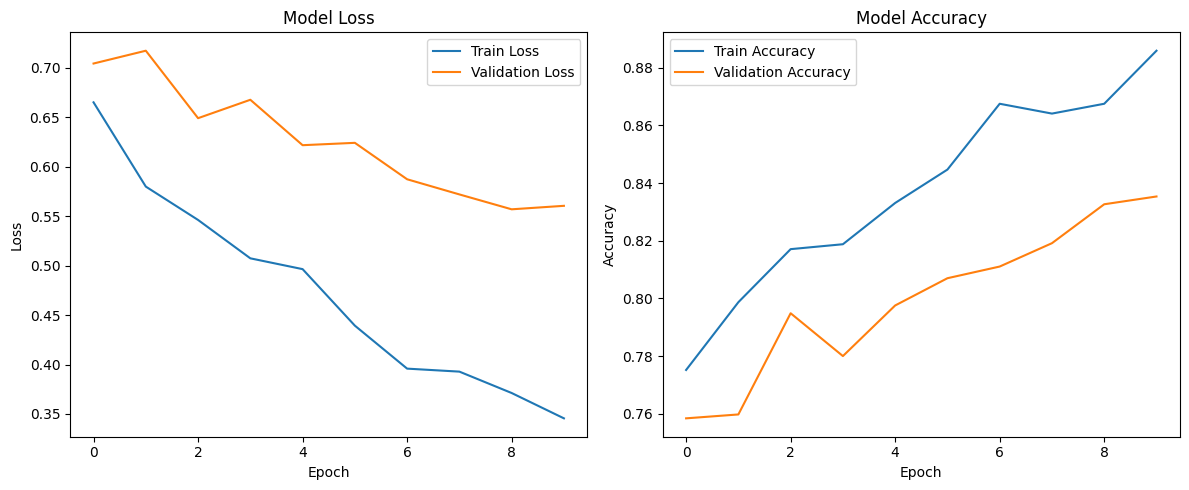

In [11]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# loss plot
plt.subplot(1, 2, 1)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

## Inference

In [27]:
def load_and_preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

def predict_celebrity(img_path):
    img_array = load_and_preprocess_image(img_path)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions[0])
    class_names = list(train_generator.class_indices.keys())
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name

In [28]:
for img_path in os.listdir("/Test") :
  if img_path == ".ipynb_checkpoints" :
    continue
  predicted_celebrity = predict_celebrity("/Test/" + img_path)
  print(f'The predicted celebrity is: {predicted_celebrity} for {img_path}')

1/1 [==============================] - 0s 88ms/step
The predicted celebrity is: Hugh Jackman for test9_hugh.jpg
1/1 [==============================] - 0s 83ms/step
The predicted celebrity is: Megan Fox for Test1_megan.jpg
1/1 [==============================] - 0s 82ms/step
The predicted celebrity is: Tom Cruise for test12_tomCruise.png
1/1 [==============================] - 0s 94ms/step
The predicted celebrity is: Aishwarya Rai for test10_aish.jpg
1/1 [==============================] - 0s 92ms/step
The predicted celebrity is: Scarlett Johansson for test11_scarlett.png
1/1 [==============================] - 0s 84ms/step
The predicted celebrity is: Jennifer Lawrence for Test2_Jennifer.jpg
1/1 [==============================] - 0s 82ms/step
The predicted celebrity is: Natalie Portman for test13_natalia.png
1/1 [==============================] - 0s 83ms/step
The predicted celebrity is: Johnny Depp for test8_johneydepp.png
1/1 [==============================] - 0s 86ms/step
The predicted ce